In [2]:
%%capture

%run ML_Record_Mining_JN.ipynb

In [3]:
# Loading libraries for modeling
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import time

import os
path = r'/Users/seiryu8808/Desktop/UWinsc/Github/UnacquiredSites/src/output'

# Options
pd.options.mode.chained_assignment = None

## Simple Modeling for Sitenames

First, we need to encode the text data into vectors in order to apply a Classification algorithm.

In [21]:
data = nlp_bib_neotoma[['_gddid', 'sentid', 'words', 'words_as_string', 'sitenames_l', 'intersection_words_sitenames']]

In [44]:
stop_words = stopwords.words('english')
other_stop_words = 'lake',',', 'bog', 'laguna', 'pond', 'lago', "'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'

for i in other_stop_words:
    stop_words.append(i)

In [23]:
data['has_sitename'] = data['intersection_words_sitenames'].apply(len) != 0
# Map True to One and False to Zero
data['has_sitename'] = data['has_sitename'].astype(int)

# Reduce data to columns of interest for this task.
data = data[['words_as_string', 'has_sitename']]

# Define corpus for CountVectorizer
corpus = data['words_as_string'].tolist()

# Split data into training and testing sets
data_train, data_test = train_test_split(data, test_size = 0.20, random_state = 12)

# Translate words to vectors
# This model can add stopwords, punctuation, etc.
# For now, use all words.
vec = CountVectorizer(min_df=2, 
                      stop_words= stop_words,
                      tokenizer=nltk.word_tokenize)

# Fit and transform training
X_train = vec.fit_transform(data_train['words_as_string']) 
y_train = data_train['has_sitename']

# Transform test data without fitting
X_test = vec.transform(data_test['words_as_string']) 
y_test = data_test['has_sitename']

/Users/seiryu8808/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Let's try to fit into different models to see which one renders the best performance. Take into consideration that this model will eventually be escalated to a bigger amount of data.

In [29]:
classifiers = {
    'knn'           : KNeighborsClassifier(),
    'decision tree' : DecisionTreeClassifier(random_state = 0, max_depth = 15),
    'random forest' : RandomForestClassifier(n_estimators = 10)
#    'SVM'           : SVC(C = 100, gamma = "scale"),
#    'logistic reg'  : LogisticRegression(solver="lbfgs", max_iter = 10000)
}

In [30]:
def create_scores(classifiers = classifiers, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    train_scores = dict()
    test_scores = dict()
    training_times = dict()

    for classifier_name, classifier_obj in classifiers.items():
     #   print("Fitting", classifier_name)
        t = time.time()
        classifier_obj.fit(X_train, y_train)

        training_times[classifier_name] = time.time() - t
        train_scores[classifier_name] = classifier_obj.score(X_train, y_train)
        test_scores[classifier_name] = classifier_obj.score(X_test, y_test)

    data = {"train acc": train_scores, "valid acc" : test_scores, "training time (s)" : training_times}
    df = pd.DataFrame(data, columns = data.keys())
    df.index = list(classifiers.keys())
    return df

In [31]:
scores_df = create_scores()
scores_df

,train acc,valid acc,training time (s)
knn,0.904351,0.886581,0.022418
decision tree,0.910798,0.905148,1.762849
random forest,0.990470,0.920902,23.287596


We can see there is overfitting happening, since all testing scores are too good to be true.   
We also have to take into consideration that just 230 sentences have both coordinates out of over 100,000.   
With this data unbalance, guessing 0 over all sentences would still be a very high accuracy.

## Checking different scores such as confusion matrices

From the above matrix, we can see that SVM and Logistic Regression are computationally expensive. Taking into consideration that this experiment will eventually be scaled to a larger data set, let's discard these two methods. 

One way to know if a method is not missclassifying items, would be to check the confusion matrix and see how many false possitives or false negatives it has.

In [32]:
for classifier_name, classifier_obj in classifiers.items():
    print("Confusion Matrix", classifier_name)
    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred).ravel()
    print(conf_mat)

Confusion Matrix knn
[18755   209  2210   154]
Confusion Matrix decision tree
[18871    93  1930   434]
Confusion Matrix random forest
[18816   148  1522   842]


Although KNN has less false positives, it has 11 more false negatives. True positives are being completely missed. 
So, although it is faster to train, it is not a good model.

Let's then work with Decission Tree classifier and tune it to find the best parameters.

In [33]:
min_samples_split_dict = {'sample_size':[], 'train_accuracy':[], 'test_accuracy' :[]}

for nsamples in range(2,200,20):
    model = DecisionTreeClassifier(min_samples_split = nsamples)
    model.fit(X_train, y_train)
    score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    min_samples_split_dict['sample_size'].append(nsamples)    
    min_samples_split_dict['train_accuracy'].append(score)
    min_samples_split_dict['test_accuracy'].append(test_score)
    
min_samples_split_df = pd.DataFrame(min_samples_split_dict)
min_samples_split_df

,sample_size,train_accuracy,test_accuracy
0,2,0.998113,0.924231
1,22,0.979346,0.927185
2,42,0.975689,0.926153
3,62,0.971833,0.925731
4,82,0.970754,0.927044
5,102,0.969383,0.925778
6,122,0.968129,0.926575
7,142,0.966277,0.926200
8,162,0.964167,0.925356
9,182,0.962866,0.925872


In [34]:
max_depth_dict = {'max_depth':[], 'train_accuracy':[], 'test_accuracy':[]}

for nsamples in range(100,200,10):
    model = DecisionTreeClassifier(max_depth = nsamples)
    model.fit(X_train, y_train)
    score = model.score(X_train,y_train)
    test_sc = model.score(X_test, y_test)
    max_depth_dict['max_depth'].append(nsamples)    
    max_depth_dict['train_accuracy'].append(score)
    max_depth_dict['test_accuracy'].append(test_sc)
    
max_depth_df = pd.DataFrame(max_depth_dict)
max_depth_df

,max_depth,train_accuracy,test_accuracy
0,100,0.959138,0.925638
1,110,0.961940,0.926622
2,120,0.964120,0.926341
3,130,0.966277,0.928029
4,140,0.968527,0.929717
5,150,0.970778,0.929060
6,160,0.973368,0.929107
7,170,0.973638,0.929904
8,180,0.975889,0.928263
9,190,0.977108,0.929717


In [37]:
clf = DecisionTreeClassifier(min_samples_split = 20, max_depth = 140)

In [38]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=140,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Having chosen our hyperparameters, let's examine which features are the most important features.

In [39]:
# See which features are considered important
f_imp = clf.feature_importances_

feature_importance = 100.0 * (f_imp / f_imp.max())
feature_names = vec.get_feature_names()

In [40]:
# A holder for feature_name: feature_importance
feats = {} 
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair

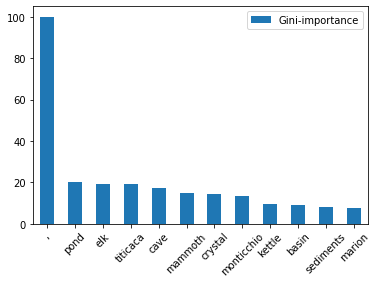

In [41]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:12].plot(kind='bar', rot=45)

In [42]:
importances.sort_values(by='Gini-importance', ascending=False)[:12]

,Gini-importance
",",100.000000
pond,20.423876
elk,19.227785
titicaca,19.063581
cave,17.156058
...,...
monticchio,13.523879
kettle,9.720231
basin,9.000566
sediments,7.932140


In [45]:
y_pred = clf.predict(X_test)

In [46]:
clf.score(X_test, y_test)

0.9285446361590397

In [47]:
confusion_matrix(y_test, y_pred).ravel()

array([18613,   351,  1173,  1191])

After removing certain stopwords and tuning hyperparameters, the model improves.

TODO:  
 Take away vocabulary such as lake, bog, lago, pond.

In [22]:
# Export csv to compare y_pred and y_test labels
guessed_label = pd.DataFrame(y_pred)
actual_label = pd.DataFrame(y_test)
actual_label = actual_label.reset_index()

# Join with sentences
original_sentence = pd.DataFrame(data_test['words_as_string'])
original_sentence = original_sentence .reset_index()

comparison_df = guessed_label.join(actual_label)
comparison_df = comparison_df.drop(columns=['index'])

comparison_df = comparison_df.join(original_sentence)
comparison_df = comparison_df.drop(columns=['index'])

In [23]:
output_file = os.path.join(path,'modeled_sentences_sitenames.tsv')
comparison_df.to_csv(output_file, sep='\t', index = False)

One of the reasons for such a poor classification with the False Negatives, it is because data  is too unbalanced. 

We are going to address that problem now.

### Balancing DataSet

Although usually more data is better, we have a very few number of sentences that satisfy the condition of having "coordinates".

In order to balance training, I will only take 300 random sentences that have no coordinates. This will be even with sentences that have coordinates and maybe this will create less noise. 

In [48]:
data = nlp_bib_neotoma[['_gddid', 'sentid', 'words', 'words_as_string', 'sitenames_l', 'intersection_words_sitenames']]

In [49]:
data['has_sitename'] = data['intersection_words_sitenames'].apply(len) != 0
# Map True to One and False to Zero
data['has_sitename'] = data['has_sitename'].astype(int)

In [50]:
# Reduce data to columns of interest
data = data[['words_as_string', 'has_sitename']]

In [51]:
from random import shuffle
data0 = data[data['has_sitename'] == 0]
data0 = data0.sample(n = 12000)
data1 = data[data['has_sitename'] == 1]
data = pd.concat([data0, data1])
data.head(2)

,words_as_string,has_sitename
6408,"Downloaded,from,www.nrcresearchpress.com,by,UN...",0
20120,"i,~,IORG,ORG,.",0


In [52]:
# Define corpus for CountVectorizer
corpus = data['words_as_string'].tolist()

# Split data into training and testing sets
data_train, data_test = train_test_split(data, test_size = 0.20, random_state = 12)

In [53]:
# Translate words to vectors
# This model can add stopwords, punctuation, etc.
# For now, use all words.
vec = CountVectorizer(min_df=2,
                      stop_words= stop_words,
                      tokenizer=nltk.word_tokenize)

# Fit and transform training
X_train = vec.fit_transform(data_train['words_as_string']) 
y_train = data_train['has_sitename']

# Transform test data without fitting
X_test = vec.transform(data_test['words_as_string']) 
y_test = data_test['has_sitename']

Using same model since we are just comparing 'Data Balancing'

In [54]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=140,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [55]:
clf.score(X_test, y_test)

0.7545818411628397

In [56]:
clf.score(X_train, y_train)

0.9144587832499341

In [57]:
# See which features are considered important
f_imp = clf.feature_importances_
feature_importance = 100.0 * (f_imp / f_imp.max())
feature_names = vec.get_feature_names()

In [58]:
# A holder for feature_name: feature_importance
feats = {} 
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair

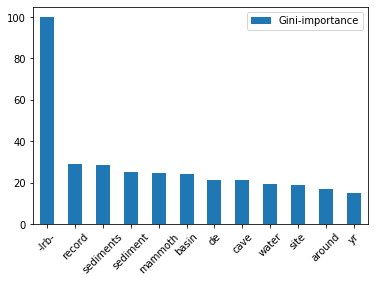

In [59]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:12].plot(kind='bar', rot=45)

In [60]:
importances.sort_values(by='Gini-importance', ascending = False)[:15]

,Gini-importance
-lrb-,100.000000
record,29.153443
sediments,28.441411
sediment,25.205125
mammoth,24.883748
...,...
around,16.997176
yr,15.128389
elk,14.446352
crystal,14.084264


In [62]:
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred).ravel()

array([1944,  483,  682, 1638])

In [64]:
guessed_label = pd.DataFrame(y_pred)
actual_label = pd.DataFrame(y_test)
actual_label = actual_label.reset_index()

In [65]:
original_sentence = pd.DataFrame(data_test['words_as_string'])
original_sentence = original_sentence .reset_index()

In [66]:
site_comparison_df_sm = guessed_label.join(actual_label)
site_comparison_df_sm = site_comparison_df_sm.drop(columns=['index'])

In [67]:
site_comparison_df_sm = site_comparison_df_sm.join(original_sentence)
site_comparison_df_sm = site_comparison_df_sm.drop(columns=['index'])
site_comparison_df_sm

,0,has_sitename,words_as_string
0,0,0,"The,R-value,diagram,-LRB-,Fig.,10,-RRB-,proved..."
1,1,0,"An,abrupt,decline,of,about,50,‰,was,followed,b..."
2,0,0,"Abstracts,American,Quaternary,Association,1982..."
3,0,0,"American,Journal,of,Science,,,256,,,341-359,."
4,0,0,"This,paper,beneﬁtted,from,the,comments,of,M.,G..."
...,...,...,...
4742,0,0,"Schnitker,,,D.,&,Jorgensen,,,J.,-LRB-,1990,-RR..."
4743,1,1,"Age-depth,models,for,the,Minden,Bog,and,Hole,B..."
4744,0,1,"The,cores,from,Roque,Island,and,Schoodic,Penin..."
4745,0,0,"J.,Paleolimnol.,,,19,,,417,--,427,."


In [70]:
import os
output_file = os.path.join(path,'small_modelled_site_sentences.tsv')
site_comparison_df_sm.to_csv(output_file, sep='\t', index = False)